<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 4
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

Esta tarea es una continuacion de la tarea semanal 3, en la que nos proponemos hacer un analisis mas profundo de la cuantizacion y 
analizar el espectro de las diferentes senales y los pisos de ruido

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from signal_generator import *

Vp = 1     # Amplitud de la senoidal
Vdc = 0    # Valor medio de la senoidal
fs = 1000  # Frecuencia de sampleo de la senoidal
N = fs      ## IMPORTANTE PARA VER LA DISTRIBUCION DE PROBABILIDAD
f = fs/N   # Frecuencia de la senoidal
fase = 0   # fase de la senoidal


# Parametros del ADC
bits = 4
Vref = 2*Vp
num_pasos = 2**(bits)
q = 2*Vref/(num_pasos)      ## No le resto 1 a num_pasos por como hago el redondeo

## Ruido
kn = 1
Pn = kn * q**2/12

print(f"\n\nNuestro ADC tiene un rango de {-Vref} a {Vref} y es de {bits:.0f} bits, dandonos un total de {num_pasos} pasos y \
un paso de cuantizacion q de {q:.4f}V \nPara calcular q tomamos que la cantidad de pasos es 2**(bits) + 1 por lo que explicaremos en\
la seccion de Discretizacion \n\n")
print(f"Tambien insertamos un ruido de distribucion normal con una potencia de {Pn:.4e} W\n\n")




Nuestro ADC tiene un rango de -2 a 2 y es de 4 bits, dandonos un total de 16 pasos y un paso de cuantizacion q de 0.2500V 
Para calcular q tomamos que la cantidad de pasos es 2**(bits) + 1 por lo que explicaremos enla seccion de Discretizacion 


Tambien insertamos un ruido de distribucion normal con una potencia de 5.2083e-03 W




La media del ruido es: 0.002476
La varianza del ruido es: 0.004930


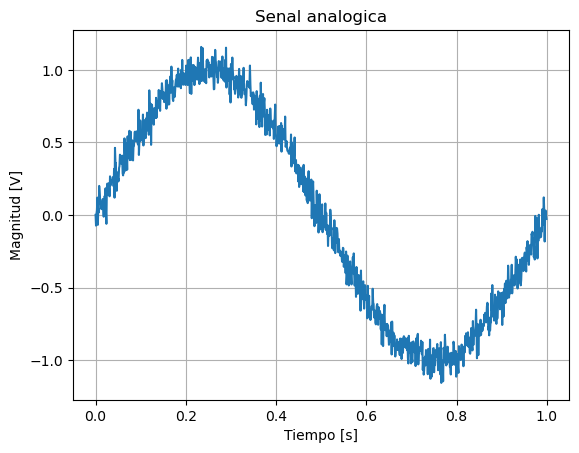

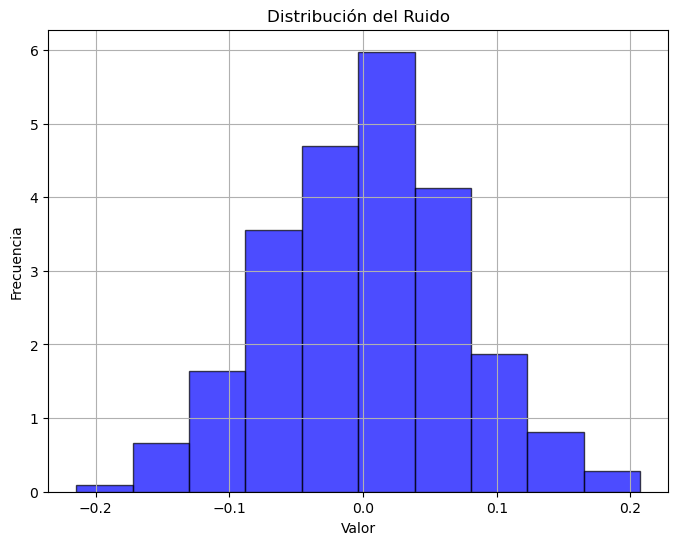

In [3]:
## Nuestro generador de senal va a generar nuestra senal discreta muestreada a 
## fs pero sin cuantizar su ampltiud
[t,x_analogica]   = signal_gen(Vp, Vdc, f, fase, N, fs)
## Ahora agregamos ruido a nuestra senal
n = np.random.normal(0, np.sqrt(Pn),len(t))
varianza = np.var(n, ddof = 1)
media   = np.mean(n)
print(f'La media del ruido es: {media:.6f}')
print(f'La varianza del ruido es: {varianza:.6f}')
x = x_analogica + n

plt.figure(1)
plt.title("Senal analogica")
plt.plot(t,x)
plt.ylabel("Magnitud [V]")
plt.xlabel("Tiempo [s]")
plt.grid()
plt.show()


## Hacemos un histograma del ruido para verificar su distribucion
plt.figure(4, figsize=(8,6))
plt.hist(n, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribución del Ruido')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

## Discretrizacion

Para discretizar la senal se penso en principio, en pasar toda la senal al rango positivo sumandole +Vref y aplicando la siguiente ecuacion a partir de una regla de 3 simples y redondeando el resultado

$ x\_disc = \Large \frac{x * 2*Vref}{num\_pasos-1}$

De esta forma tenemos en cuenta que la cantidad de pasos totales son $ 2^{bits} - 1$, pero no nos permite usar el rango de en su totalidad, ya que $V_{ref}$ o $-V_{ref}$ deberian quedar excluidas. A efectos de esta paractica, hacemos que el ADC tenga un paso extra para contemplar ambos valores y hacemos un redondeo directo por el paso de cuantizacion q.

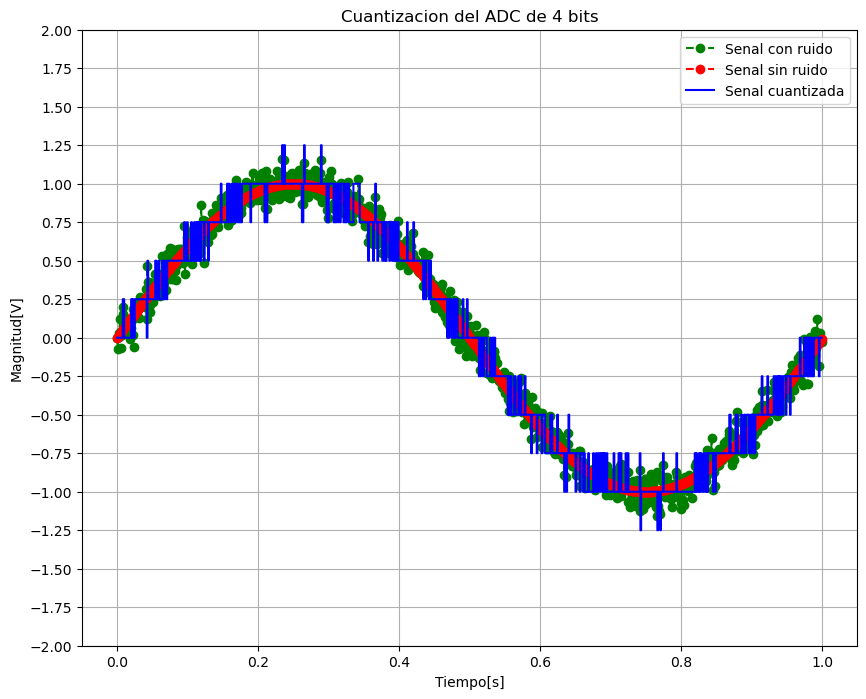

In [4]:
x_disc = np.round(x/q)*q 

plt.figure(2, figsize=(10,8))
plt.plot(t,x, "o--", color = 'green'  ,label = 'Senal con ruido')
plt.plot(t,x_analogica, "o--", color = 'red',label = 'Senal sin ruido')
plt.step(t,x_disc,where = 'post' , color = 'blue' ,label = 'Senal cuantizada')
plt.title(f"Cuantizacion del ADC de {bits} bits")
## Para mostrar los valores discretos y sus puntos medios
grid_levels = np.linspace(-Vref, Vref, num_pasos+1) 
plt.yticks(grid_levels)
plt.xlabel("Tiempo[s]")
plt.ylabel("Magnitud[V]")
plt.legend()        # Para que muestre los labels
plt.grid()
plt.show()

## Analisis del error

Esta cuantizacion de la senal trae la introduccion de un "error", el error de cuantizacion.
Esto se debe a la diferencia del valor real de la senal contra el valor de lectura del ADC.
Vamos a graficarlo y analizarlo

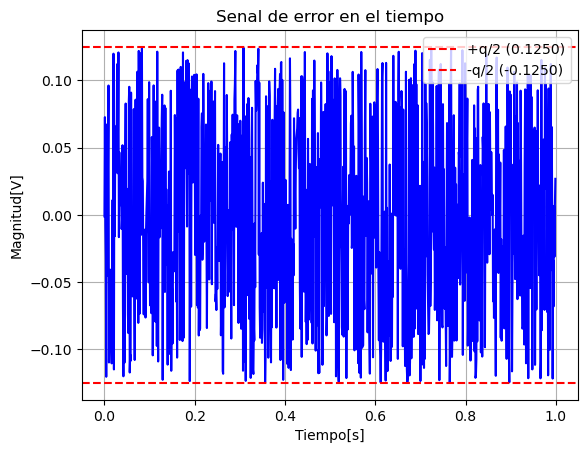

In [5]:
# ## Pasamos a realizar el analisis estadistico del error
e = x_disc - x

# Ploteamos el error y verificamos que se encue
plt.figure(3)
plt.plot(t, e, color = 'blue')
plt.axhline(q/2, color = "red", linestyle = '--', label = f"+q/2 ({q/2:.4f})")
plt.axhline(-q/2, color = "red", linestyle = '--', label = f"-q/2 ({-q/2:.4f})")
plt.title("Senal de error en el tiempo")
plt.xlabel("Tiempo[s]")
plt.ylabel("Magnitud[V]")
plt.legend()
plt.grid()
plt.show()

## Analisis espectral

Vamos a analizar las senales espectralmente, comparando los pisos de ruido digital y analogico.

Por ruido analogico, nos referimos al ruido "de ambiente" que ya esta en la senal antes de samplearla con el ADC. Luego, el ruido de cuantizacion se relaciona con la definicion que tiene el ADC y depende de sus bits y tension de referencia.

Conocer el piso de ruido analogico nos ayuda a definir la cuantizacion, ya que el ruido de cuantizacion

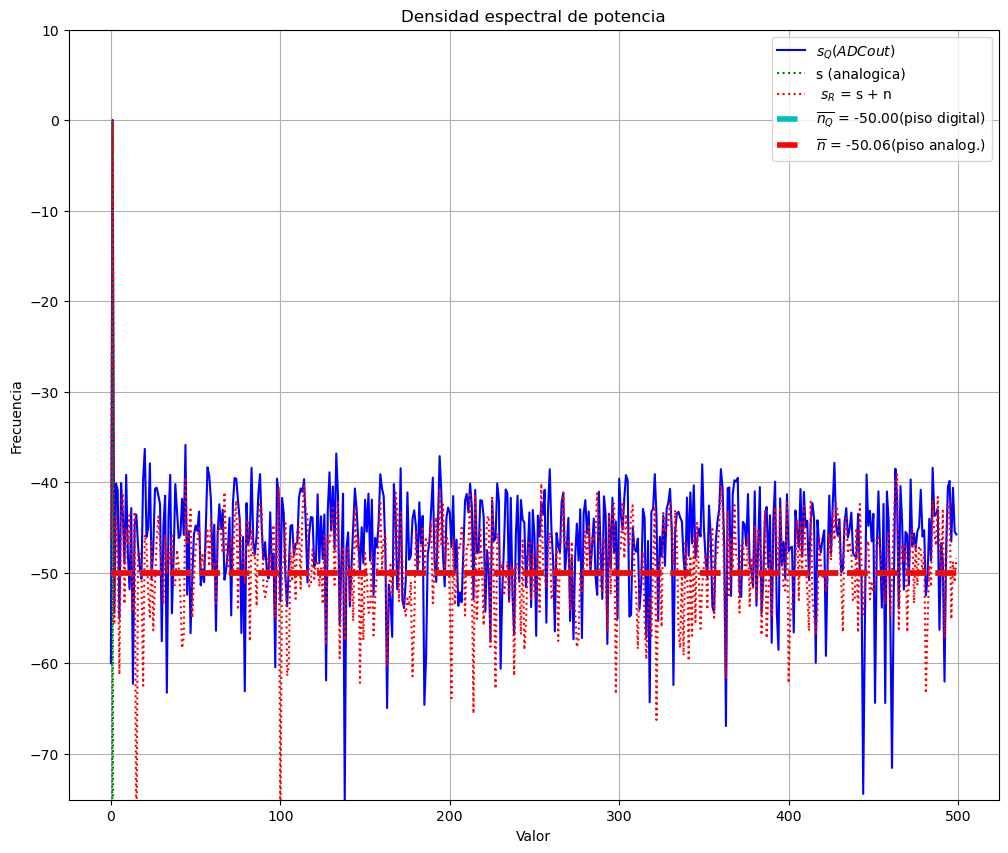

In [6]:
n_fft = np.fft.fft(n)/N
x_analog_fft = np.fft.fft(x_analogica)/N
x_fft = np.fft.fft(x)/N
x_disc_fft = np.fft.fft(x_disc)/N
e_fft = np.fft.fft(e)/N
## Creamos el vector de frecuencias ordenado, uso estas funciones por simplicidad
## y ahorrarme el cheque de si N es par o impar
freqs = np.fft.fftfreq(N,1/fs)
#freqs= np.fft.fftshift(freqs)
bfreqs = (freqs >= 0) #fs/2

n_mean = np.mean(np.abs(n_fft)**2)
e_mean = np.mean(np.abs(e_fft)**2)

plt.figure(4,figsize=(12,10))
## Ploteamos la salida del DAC
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_disc_fft[bfreqs])), color = 'blue', label = '$s_{Q} (ADC out)$', )


## Ploteamos la senal de entrada sin ruido
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_analog_fft[bfreqs])), color = 'green', ls= 'dotted', label = 's (analogica)', )

## Ploteamos la senal con ruido
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_fft[bfreqs])), color = 'red', ls= 'dotted', label = f' $s_{{R}}$ = s + n' )

plt.plot(np.array([freqs[bfreqs][0],freqs[bfreqs][-1]]), 10*np.log10(2*np.array([e_mean,e_mean])), '--c', lw= 4,label = f'$\\overline{{n_Q}}$ = {10*np.log10(2*e_mean):.2f}(piso digital)')
plt.plot(np.array([freqs[bfreqs][0],freqs[bfreqs][-1]]), 10*np.log10(2*np.array([n_mean,n_mean])), '--r', lw= 4,label = f'$\\overline{{n}}$ = {10*np.log10(2*n_mean):.2f}(piso analog.)')

plt.title('Densidad espectral de potencia')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.ylim((1.5*np.min(10* np.log10(2* np.array([n_mean, n_mean]))),10))
plt.grid(True)
plt.legend()
plt.show()


El piso digital y el piso analogico practicamente coinciden, este es un caso limite que explicaremos al final del notebook



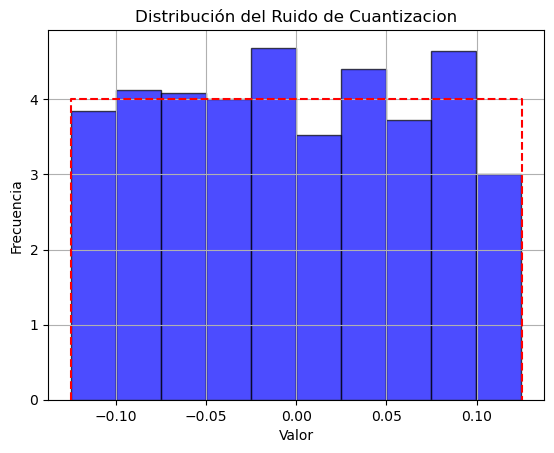

La media del ruido de cuantizacion es: 0.002476
La varianza del ruido de cuantizacion es: 0.004930


In [7]:
## Histograma del ruido de cuantizacion

plt.figure(6)
plt.hist(e, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, 1/q, 1/q, 0]), '--r' )
plt.title('Distribución del Ruido de Cuantizacion')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

varianza_e = np.var(e, ddof = 1)
media_e   = np.mean(e)
print(f'La media del ruido de cuantizacion es: {media:.6f}')
print(f'La varianza del ruido de cuantizacion es: {varianza:.6f}')

## ¿Que pasa si variamos el ruido y los bits del ADC?

Vamos a hacer el mismo analisis pero con mas bits en el ADC, asi como mayor potencia de ruido, ajustado por nuestra variable kn

In [55]:
# Parametros del ADC
bits = 16
Vref = 2*Vp
num_pasos = 2**(bits)
q = 2*Vref/(num_pasos)      ## No le resto 1 a num_pasos por como hago el redondeo

## Ruido
kn = 10
Pn = kn * q**2/12

print(f"\n\nNuestro ADC tiene un rango de {-Vref} a {Vref} y es de {bits:.0f} bits, dandonos un total de {num_pasos} pasos y \
un paso de cuantizacion q de {q:.4f}V \nPara calcular q tomamos que la cantidad de pasos es 2**(bits) + 1 por lo que explicaremos en\
la seccion de Discretizacion \n\n")
print(f"Tambien insertamos un ruido de distribucion normal con una potencia de {Pn:.4e} W\n\n")



Nuestro ADC tiene un rango de -2 a 2 y es de 16 bits, dandonos un total de 65536 pasos y un paso de cuantizacion q de 0.0001V 
Para calcular q tomamos que la cantidad de pasos es 2**(bits) + 1 por lo que explicaremos enla seccion de Discretizacion 


Tambien insertamos un ruido de distribucion normal con una potencia de 3.1044e-09 W




In [56]:
## Nuestro generador de senal va a generar nuestra senal discreta muestreada a 
## fs pero sin cuantizar su ampltiud
[t,x_analogica]   = signal_gen(Vp, Vdc, f, fase, N, fs)
## Ahora agregamos ruido a nuestra senal
n = np.random.normal(0, np.sqrt(Pn),len(t))
varianza = np.var(n, ddof = 1)
media   = np.mean(n)
print(f'La media del ruido es: {media:.6f}')
print(f'La varianza del ruido es: {varianza:.6f}')
x = x_analogica + n2

La media del ruido es: 0.000001
La varianza del ruido es: 0.000000


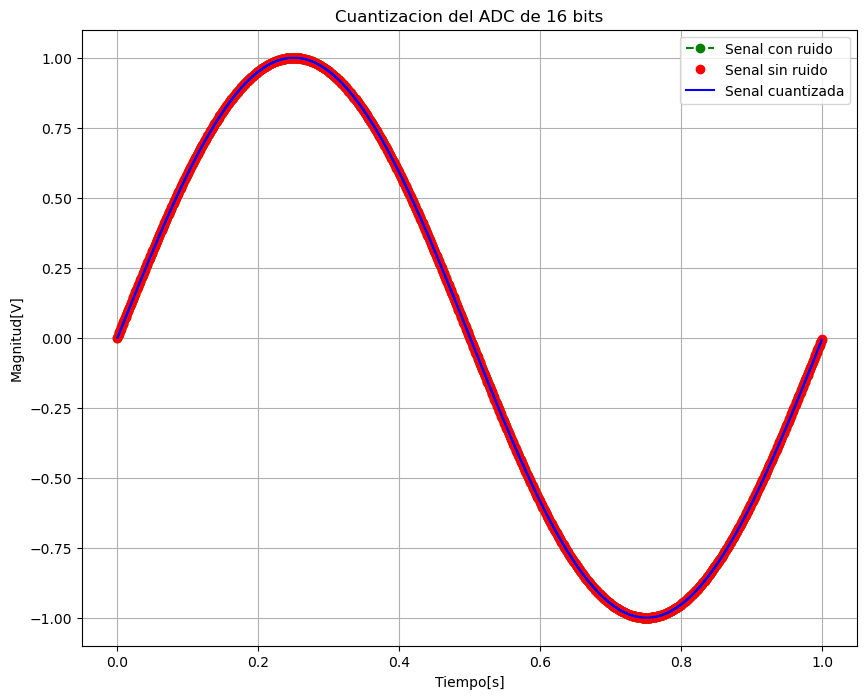

In [57]:
x_disc = np.round(x2/q)*q 

plt.figure(7, figsize=(10,8))
plt.plot(t,x, "o--", color = 'green'  ,label = 'Senal con ruido')
plt.plot(t,x_analogica, "o--", lw = 00, color = 'red',label = 'Senal sin ruido')
plt.step(t,x_disc,where = 'post' , color = 'blue' ,label = 'Senal cuantizada')
plt.title(f"Cuantizacion del ADC de {bits} bits")
plt.xlabel("Tiempo[s]")
plt.ylabel("Magnitud[V]")
plt.legend()        # Para que muestre los labels
plt.grid()
plt.show()

Al subir la cantidad de bits a 16, y tener el ruido ajustado por q, practicamente no se nota en el grafico, asi como tampoco se nota que la Senal cuantizada sean pasos del ADC, ya que estos pasos son mucho menor que para un ADC de 4 bits

## Analisis espectral para 16 bits y kn = 10

Vamos a repetir el analisis espectral para estas variables y ver como varian los resultados

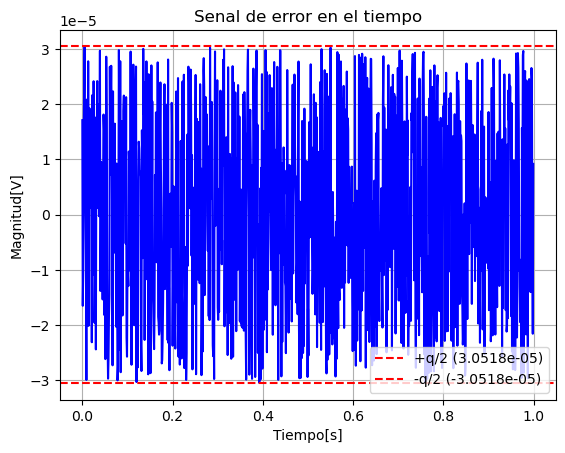

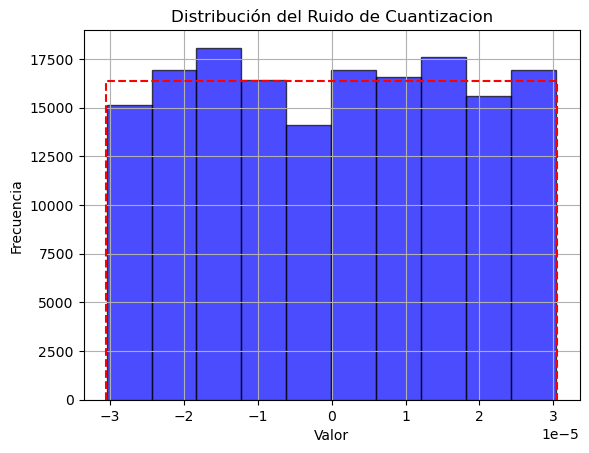

La media del ruido de cuantizacion es: 1.352707e-06
La varianza del ruido de cuantizacion es: 3.168545e-09


In [58]:
# ## Pasamos a realizar el analisis estadistico del error
e = x_disc - x

# Ploteamos el error y verificamos que se encue
plt.figure(8)
plt.plot(t, e, color = 'blue')
plt.axhline(q/2, color = "red", linestyle = '--', label = f"+q/2 ({q/2:.4e})")
plt.axhline(-q/2, color = "red", linestyle = '--', label = f"-q/2 ({-q/2:.4e})")
plt.title("Senal de error en el tiempo")
plt.xlabel("Tiempo[s]")
plt.ylabel("Magnitud[V]")
plt.legend()
plt.grid()
plt.show()

## Histograma del ruido de cuantizacion

plt.figure(9)
plt.hist(e, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, 1/q, 1/q, 0]), '--r' )
plt.title('Distribución del Ruido de Cuantizacion')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

varianza_e = np.var(e, ddof = 1)
media_e   = np.mean(e)
print(f'La media del ruido de cuantizacion es: {media:.6e}')
print(f'La varianza del ruido de cuantizacion es: {varianza:.6e}')

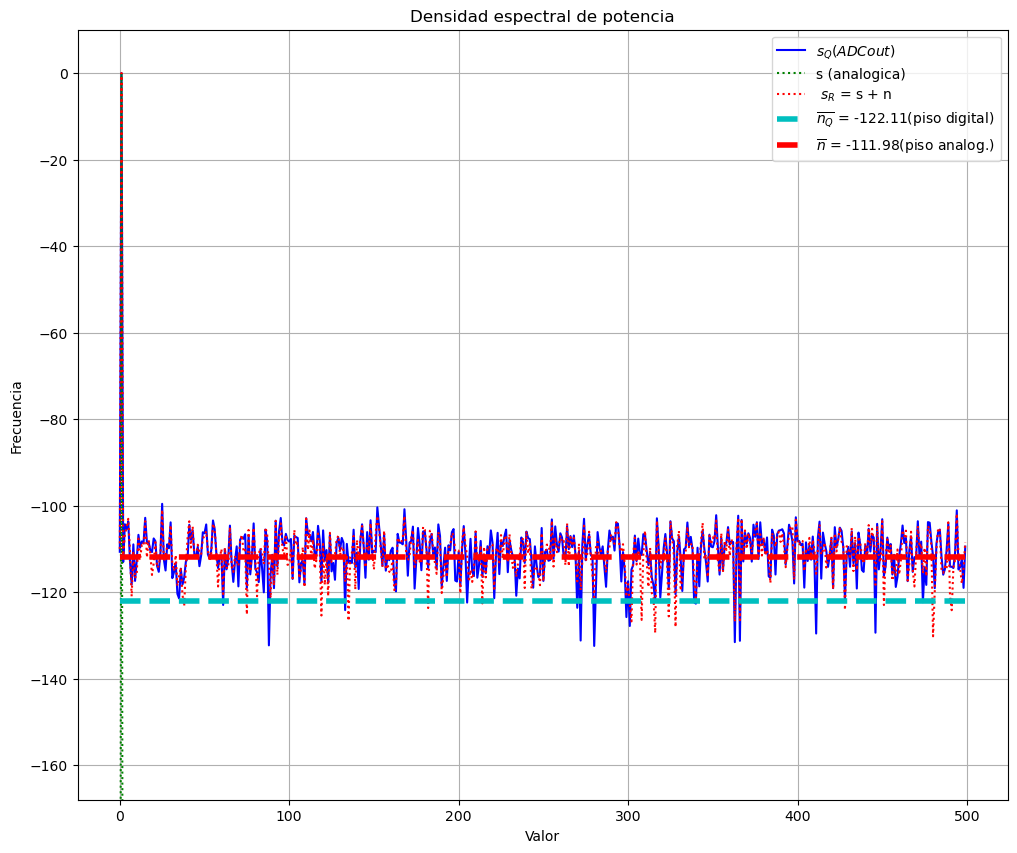

In [59]:
n_fft = np.fft.fft(n)/N
x_analog_fft = np.fft.fft(x_analogica)/N
x_fft = np.fft.fft(x2)/N
x_disc_fft = np.fft.fft(x_disc)/N
e_fft = np.fft.fft(e)/N
## Creamos el vector de frecuencias ordenado, uso estas funciones por simplicidad
## y ahorrarme el cheque de si N es par o impar
freqs = np.fft.fftfreq(N,1/fs)
#freqs= np.fft.fftshift(freqs)
bfreqs = (freqs >= 0) #fs/2

n_mean = np.mean(np.abs(n_fft)**2)
e_mean = np.mean(np.abs(e_fft)**2)

plt.figure(10,figsize=(12,10))
## Ploteamos la salida del DAC
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_disc_fft[bfreqs])), color = 'blue', label = '$s_{Q} (ADC out)$', )


## Ploteamos la senal de entrada sin ruido
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_analog_fft[bfreqs])), color = 'green', ls= 'dotted', label = 's (analogica)', )

## Ploteamos la senal con ruido
plt.plot(freqs[bfreqs], 20*np.log10(2*np.abs(x_fft[bfreqs])), color = 'red', ls= 'dotted', label = f' $s_{{R}}$ = s + n' )

plt.plot(np.array([freqs[bfreqs][0],freqs[bfreqs][-1]]), 10*np.log10(2*np.array([e_mean,e_mean])), '--c', lw= 4,label = f'$\\overline{{n_Q}}$ = {10*np.log10(2*e_mean):.2f}(piso digital)')
plt.plot(np.array([freqs[bfreqs][0],freqs[bfreqs][-1]]), 10*np.log10(2*np.array([n_mean,n_mean])), '--r', lw= 4,label = f'$\\overline{{n}}$ = {10*np.log10(2*n_mean):.2f}(piso analog.)')

plt.title('Densidad espectral de potencia')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.ylim((1.5*np.min(10* np.log10(2* np.array([n_mean, n_mean]))),10))
plt.grid(True)
plt.legend()
plt.show()

## Conclusiones

Vemos como al aumentar la cantidad la cantidad el piso de ruido digital baja, esto se da ya que el paso de cuantizacion es menor y el ADC es capaz de distinguir senales de menor amplitud.

Siempre queremos tener casos como el anterior, donde el piso de ruido digital esta por debajo del analogico, de esta forma evitamos interferencias en el analisis de la senal por nuestra cuantizacion. 

El primer analisis que hicimos es un caso limite donde ambos pisos coinciden, para ese caso deberiamos aumentar la cantidad de bits para bajar el piso de ruido digital